In [1]:
import json
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
# DoSRandom_0709 = 5090093, DoSRandom_1416 = 1400517
BSM_SIZE = 5090093
N_FEATURES = 23

In [8]:
root_dir = 'DoSRandom_0709/'


filenames = glob.glob(root_dir + '**/traceJSON*.json', recursive=True)

attacker_sender_map = {}

for filepath in filenames:
    filename = filepath.split('/')[-1]
    _, vehicle, _, attacker = filename.split('-')[:4] # Rever definições da nomenclatura
    attacker_type = int(attacker[1:])
    vehicle_id = int(vehicle)
    attacker_sender_map[vehicle_id] = attacker_type
         
# i = 0
# for filepath in tqdm(filenames):
#     f = open(filepath)
#     for line in f:
#         i += 1
# print(i)
    
bsm = np.memmap('bsmdos.memmap', dtype='float32', mode='w+', shape=(BSM_SIZE, N_FEATURES))
bsm_pos = 0
for filepath in (pbar := tqdm(filenames)):
    f = open(filepath)
    receiver = int(filepath.split('/')[-1].split('-')[1])
    pbar.set_description("Vehicle ID {}".format(receiver))
    gps = None
    for line in f:
        data = json.loads(line)
        if data['type'] == 2:
            gps = data
        elif data['type'] == 3:
            attack_type = attacker_sender_map.get(data['sender'], None)
            if attack_type is not None:
                out = (
                    data['messageID'],
                    data['rcvTime'],
                    data['sendTime'],
                    receiver,
                    data['sender'],
                    attack_type,
                    data['pos'][0],
                    data['pos'][1],
                    data['spd'][0],
                    data['spd'][1],
                    data['acl'][0],
                    data['acl'][1],
                    data['hed'][0],
                    data['hed'][1],
                    gps['rcvTime'],
                    gps['pos'][0],
                    gps['pos'][1],
                    gps['spd'][0],
                    gps['spd'][1],
                    gps['acl'][0],
                    gps['acl'][1],
                    gps['hed'][0],
                    gps['hed'][1],
                )
                bsm[bsm_pos] = out
                bsm_pos += 1
                
root_dir = 'MixAll_0024/'

  0%|          | 0/4068 [00:00<?, ?it/s]

5090093


  0%|          | 0/4068 [00:00<?, ?it/s]

In [66]:
bsm = np.memmap('bsmdos.memmap', dtype='float32', mode='r', shape=(BSM_SIZE, N_FEATURES))
df = pd.DataFrame(bsm, columns=[
    'message_id',
    'bsm_rcv_time',
    'bsm_snd_time',
    'receiver',
    'sender',
    'attack_type',
    'snd_pos_x',
    'snd_pos_y',
    'snd_spd_x',
    'snd_spd_y',
    'snd_acl_x',
    'snd_acl_y',
    'snd_hed_x',
    'snd_hed_y',
    'gps_rcv_time',
    'rcv_pos_x',
    'rcv_pos_y',
    'rcv_spd_x',
    'rcv_spd_y',
    'rcv_acl_x',
    'rcv_acl_y',
    'rcv_hed_x',
    'rcv_hed_y',
])#.drop_duplicates(subset='message_id')#.set_index('message_id')
df = df[df.attack_type.isin([0, 14])]
df = df[df.message_id != 0]
df.drop(columns=['gps_rcv_time'], inplace=True)
df = df.sort_values(['sender', 'bsm_snd_time']).reset_index(drop=True)
df

,message_id,bsm_rcv_time,bsm_snd_time,receiver,sender,attack_type,snd_pos_x,snd_pos_y,snd_spd_x,snd_spd_y,...,snd_hed_x,snd_hed_y,rcv_pos_x,rcv_pos_y,rcv_spd_x,rcv_spd_y,rcv_acl_x,rcv_acl_y,rcv_hed_x,rcv_hed_y
0,30704.0,25212.603516,25212.603516,45.0,9.0,0.0,257.643921,141.896606,-2.410001,14.316096,...,-0.163225,0.986589,265.531769,46.207878,-0.225154,2.178819,-0.211869,2.050554,-0.102790,0.994703
1,31035.0,25213.603516,25213.603516,45.0,9.0,0.0,255.159973,156.183960,-2.566648,14.210019,...,-0.174971,0.984574,268.473450,49.805576,-0.443232,4.275898,-0.236238,2.279278,-0.103106,0.994670
2,31276.0,25214.603516,25214.603516,45.0,9.0,0.0,252.895309,170.462082,-2.342860,14.254301,...,-0.159290,0.987232,268.092590,55.342793,-0.671703,6.479973,-0.172989,1.669152,-0.101872,0.994798
3,31517.0,25215.603516,25215.603516,45.0,9.0,0.0,250.568130,184.796082,-2.352868,14.315008,...,-0.159290,0.987232,270.404297,63.332584,-1.120065,8.541940,-0.314249,2.396708,-0.126068,0.992022
4,31758.0,25216.603516,25216.603516,45.0,9.0,0.0,248.498978,199.129242,-2.079337,14.360960,...,-0.140398,0.990095,268.713684,72.929062,-1.636166,10.526562,-0.295635,1.902114,-0.141384,0.989955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4679306,90387352.0,32398.587891,32398.587891,24087.0,24411.0,14.0,880.237915,448.160858,36.325401,25.845148,...,-0.098634,-0.252333,876.414001,709.241394,9.151532,-8.865325,0.107193,-0.102219,0.580171,-0.814495
4679307,90392256.0,32399.087891,32399.087891,24399.0,24411.0,14.0,464.213776,1369.368774,26.715353,39.256348,...,0.940712,-0.693935,940.392334,659.704529,0.000379,0.000379,0.000025,0.000025,-0.620070,-0.784547
4679308,90392256.0,32399.087891,32399.087891,24087.0,24411.0,14.0,464.213776,1369.368774,26.715353,39.256348,...,0.940712,-0.693935,885.580933,700.374817,9.155451,-8.877271,-0.457214,0.445040,0.581093,-0.813837
4679309,90397520.0,32399.587891,32399.587891,24399.0,24411.0,14.0,523.923462,75.133499,29.338928,19.557924,...,0.193756,-0.264584,940.392334,659.704529,0.000379,0.000379,0.000025,0.000025,-0.620070,-0.784547


<Axes: xlabel='bsm_snd_time'>

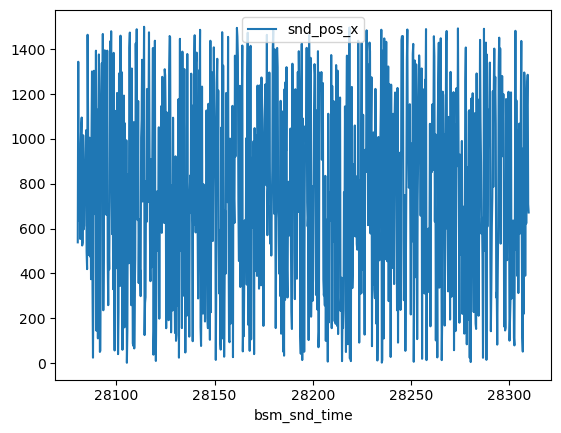

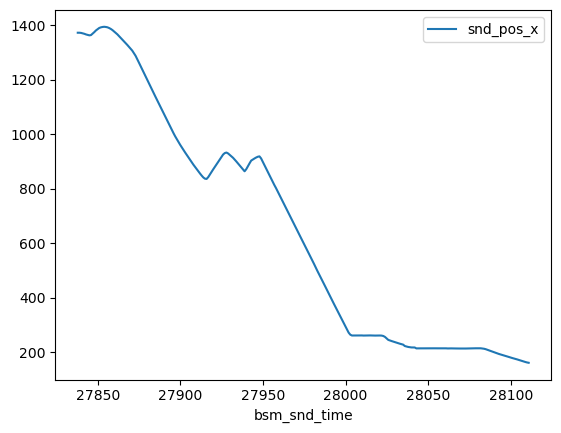

In [67]:
df[df.sender == 8571].plot(x='bsm_snd_time', y='snd_pos_x')

df[df.sender == 7779].plot(x='bsm_snd_time', y='snd_pos_x')

In [69]:
# filter for prototyping
df_s = df.copy()[:round(df.shape[0] * 0.03)]

split = round(df_s.shape[0] * 0.5)

train = df_s[:split]
filtered_train = train[train.attack_type < 10].drop(columns=['attack_type'])
filtered_train.to_csv('out_veremi_dos/train.csv')

train = train.drop(columns=['attack_type'])
train.to_csv('out_veremi_dos/train_no_filter.csv')

test = df_s[split:].drop(columns=['attack_type'])
test.to_csv('out_veremi_dos/test.csv')

y = (df_s['attack_type'] >= 10)[split:].astype(int)

labels = pd.concat([y] * len(test.columns), ignore_index=True, axis=1)
labels.to_csv('out_veremi_dos/labels.csv')

df_test_split = df_s[split:]

for i in range(10, 20):
    test_i = df_test_split[df_test_split.attack_type.isin((i, 0))].copy()
    
    y = (test_i.attack_type == i).astype(int)
    test_i.drop(columns=['attack_type'], inplace=True)
    
    labels_i = pd.concat([y] * len(test_i.columns), ignore_index=True, axis=1)

    test_i.to_csv(f'out_veremi_dos/test_{i}.csv')
    labels_i.to_csv(f'out_veremi_dos/labels_{i}.csv')

<Axes: >

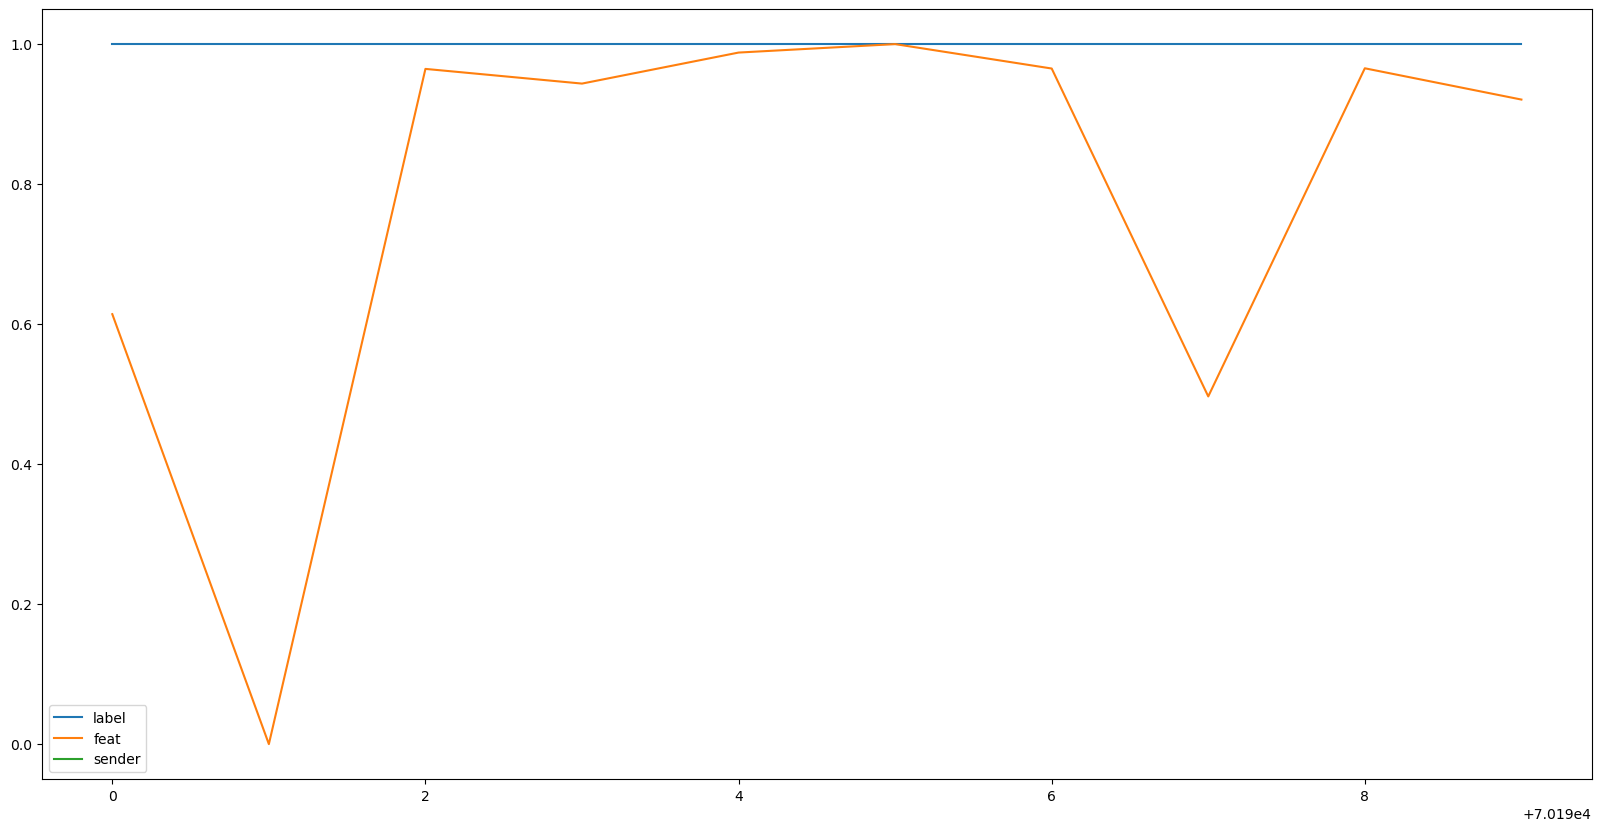

In [80]:
feat = test.rcv_pos_y.head(10)
sender = test.sender.head(10)

feat_norm = (feat - feat.min()) / (feat.max() - feat.min())
sender_norm = (sender - sender.min()) / (sender.max() - sender.min())

pd.DataFrame({ 'label': labels[0].head(10), 'feat': feat_norm, 'sender': sender_norm }).plot(figsize=(20,10))